## Parse EDF and .txt with annotations to a CSV file 

In [2]:
#@title
import os
import numpy as np
import pandas as pd
import urllib.request
from datetime import datetime
!pip install mne
import mne

def to_timestamp(x: str, acq_time: datetime):
    date = datetime.strptime(x, '%H:%M:%S')
    date = datetime(acq_time.year, acq_time.month, acq_time.day, date.hour, date.minute, date.second)
    if date.hour < 12:
        date = datetime(date.year, date.month, date.day + 1, date.hour, date.minute, date.second)
    return (date.day - acq_time.day) * 24 * 3600 + (date.hour - acq_time.hour) * 3600 + (
                date.minute - acq_time.minute) * 60 + date.second - acq_time.second


def subsample(data: np.ndarray, fs: int, fs_new: int, axis=0):
    assert fs % fs_new == 0
    factor = int(fs / fs_new)
    if data.shape[axis] % factor != 0:
        print('Subsampling led to loss of %i samples, in an online setting consider using a BlockBuffer with a '
              'buffer size of a multiple of %i samples.' % (data.shape[axis] % factor, factor))
    idx_mask = np.arange(data.shape[axis], step=factor)
    return data.take(idx_mask, axis)


def read_annotation_file(path_filename: str, acq_time: datetime):
    df_annotations_data = pd.read_csv(path_filename, sep='\t', skiprows=20)
    df_annotations_data = df_annotations_data.loc[df_annotations_data["Event"].str.startswith("SLEEP")]
    df_annotations_data = df_annotations_data.rename(columns={"Time [hh:mm:ss]": "onset", "Duration[s]": "duration"})
    df_annotations_data["timestamp"] = df_annotations_data.onset.apply(lambda x: to_timestamp(x, acq_time))

    return df_annotations_data


def merge_data_file_and_annotations(data, df_annotations, fs_new):
    raw_data = data.get_data()
    fs = int(data.info["sfreq"])
    df = pd.DataFrame(raw_data.T, columns=data.info.ch_names)
    df["times"] = data.times
    df = pd.DataFrame(data=subsample(df.to_numpy(), fs, fs_new), columns=df.columns)
    
    labels = [np.nan] * df.shape[0]
    for i in range(df_annotations.shape[0] - 1):
        row_start = df_annotations.iloc[i]
        row_end = df_annotations.iloc[i + 1]
        start_pos = row_start.timestamp * fs_new
        end_pos = row_end.timestamp * fs_new
        if start_pos < len(labels):
            labels[start_pos:end_pos] = [row_start["Sleep Stage"]]*(end_pos-start_pos)
    
    df["sleepstage"] = labels
    df = df.dropna()
    
    return df


In [3]:
# Subject ID
subject_name = 'nfle4'
# New frequency
fs_new = 128
# CSV Filename
new_filename = f'{subject_name}_data_and_annotations.csv'
              
data_filename = f'{subject_name}.edf'
filename_annotations = f'{subject_name}_annotations.txt'
url_data = f'https://physionet.org/files/capslpdb/1.0.0/{subject_name}.edf?download'
url_annotations = f'https://physionet.org/files/capslpdb/1.0.0/{subject_name}.txt?download'

print(f'Downloading data file: {url_data}')
urllib.request.urlretrieve(url_data, data_filename)

print(f'Downloading annotations data file: {url_annotations}')
urllib.request.urlretrieve(url_annotations, filename_annotations)


print(f'Loading File: {data_filename}')
data_polysomnography = mne.io.read_raw_edf(data_filename)

print(f'Loading Annotations file: {filename_annotations}')
df_annotations_polysomnography = read_annotation_file(filename_annotations, data_polysomnography.info["meas_date"])

print("\n\n Example Annotations file: \n")
df_annotations_polysomnography.head(4)

Loading File: nfle4.edf
Extracting EDF parameters from /content/nfle4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Loading Annotations file: nfle4_annotations.txt


 Example Annotations file: 



,Sleep Stage,Position,onset,Event,duration,Location,timestamp
0,W,Unknown Position,21:19:00,SLEEP-S0,30,ROC-LOC,1200
1,W,Unknown Position,21:19:30,SLEEP-S0,30,ROC-LOC,1230
2,W,Unknown Position,21:20:00,SLEEP-S0,30,ROC-LOC,1260
3,W,Unknown Position,21:20:30,SLEEP-S0,30,ROC-LOC,1290


In [4]:
print(f'Merge files annotation and polysomnography data. Downsampling data from {data_polysomnography.info["sfreq"]} to {fs_new} Hz')
df_data = merge_data_file_and_annotations(data_polysomnography, df_annotations_polysomnography, fs_new)
df_data.to_csv(new_filename, index=False)
print("Data Merged")
df_data.head(4)

Merge files annotation and polysomnography data. Downsampling data from 512.0 to 128 Hz
Data Merged


,Fp2-F4,F4-C4,C4-P4,P4-O2,F8-T4,T4-T6,FP1-F3,F3-C3,C3-P3,P3-O1,F7-T3,T3-T5,C4-A1,ROC-LOC,EMG1-EMG2,ECG1-ECG2,DX1-DX2,SX1-SX2,SAO2,HR,PLETH,STAT,MIC,times,sleepstage
153600,-0.000005,2.152015e-06,0.000007,2.945665e-06,-0.000001,0.000009,-0.000004,1.236264e-06,0.000008,0.000002,0.000011,-0.000017,-4.044567e-06,-1.953155e-06,-0.000002,-0.000015,-1.525972e-08,4.120125e-07,96.018921,68.0766,0.082593,0.0,5.378805e-07,1200.000000,W
153601,-0.000009,1.083639e-06,0.000005,2.426740e-06,-0.000002,0.000007,-0.000010,8.394383e-07,0.000006,0.000010,0.000009,-0.000005,3.205128e-07,-3.814756e-06,0.000002,-0.000014,-4.577916e-08,1.678569e-07,96.018921,68.0766,0.084515,0.0,1.499199e-06,1200.007812,W
153602,-0.000013,-4.731380e-07,0.000003,1.999389e-06,-0.000001,0.000003,-0.000014,-1.266789e-06,0.000003,0.000012,0.000003,0.000005,2.548840e-06,-1.586939e-06,0.000001,-0.000003,6.866874e-07,-2.899347e-07,96.018921,68.0766,0.086301,0.0,-2.376593e-06,1200.015625,W
153603,-0.000014,-7.783883e-07,0.000003,3.510379e-07,0.000003,0.000002,-0.000013,-4.502442e-06,-0.000003,0.000010,0.000001,0.000005,-1.633089e-06,-9.155416e-07,-0.000003,0.000033,7.629860e-08,-2.288958e-07,96.018921,68.0766,0.088239,0.0,-8.812085e-07,1200.023438,W


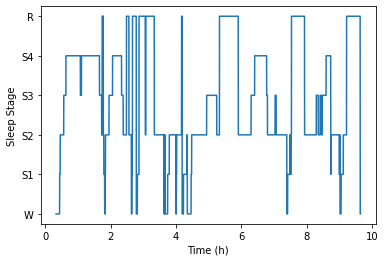

In [5]:
import matplotlib.pyplot as plt
_ = plt.plot(df_data.times/3600, df_data.sleepstage)
_ = plt.xlabel("Time (h)")
_ = plt.ylabel("Sleep Stage")

## Load CSV

In [6]:
df = pd.read_csv(new_filename)
df.head(4)

,Fp2-F4,F4-C4,C4-P4,P4-O2,F8-T4,T4-T6,FP1-F3,F3-C3,C3-P3,P3-O1,F7-T3,T3-T5,C4-A1,ROC-LOC,EMG1-EMG2,ECG1-ECG2,DX1-DX2,SX1-SX2,SAO2,HR,PLETH,STAT,MIC,times,sleepstage
0,-0.000005,2.152015e-06,0.000007,2.945665e-06,-0.000001,0.000009,-0.000004,1.236264e-06,0.000008,0.000002,0.000011,-0.000017,-4.044567e-06,-1.953155e-06,-0.000002,-0.000015,-1.525972e-08,4.120125e-07,96.018921,68.0766,0.082593,0.0,5.378805e-07,1200.000000,W
1,-0.000009,1.083639e-06,0.000005,2.426740e-06,-0.000002,0.000007,-0.000010,8.394383e-07,0.000006,0.000010,0.000009,-0.000005,3.205128e-07,-3.814756e-06,0.000002,-0.000014,-4.577916e-08,1.678569e-07,96.018921,68.0766,0.084515,0.0,1.499199e-06,1200.007812,W
2,-0.000013,-4.731380e-07,0.000003,1.999389e-06,-0.000001,0.000003,-0.000014,-1.266789e-06,0.000003,0.000012,0.000003,0.000005,2.548840e-06,-1.586939e-06,0.000001,-0.000003,6.866874e-07,-2.899347e-07,96.018921,68.0766,0.086301,0.0,-2.376593e-06,1200.015625,W
3,-0.000014,-7.783883e-07,0.000003,3.510379e-07,0.000003,0.000002,-0.000013,-4.502442e-06,-0.000003,0.000010,0.000001,0.000005,-1.633089e-06,-9.155416e-07,-0.000003,0.000033,7.629860e-08,-2.288958e-07,96.018921,68.0766,0.088239,0.0,-8.812085e-07,1200.023438,W
